In [1]:
import networkx as nx
import networkit as nk
import matplotlib.pyplot as plt
import random

from collections import Counter

Generator = nk.generators.ClusteredRandomGraphGenerator(20, 4, pin=0.95, pout=0.05)
G = Generator.generate()
nk.overview(G)
com = Generator.getCommunities()
nk.community.inspectCommunities(com, G)

Network Properties for:		G#5
nodes, edges			20, 62
directed?			False
weighted?			False
isolated nodes			0
self-loops			0
density				0.326316
clustering coefficient		0.681746
min/max/avg degree		3, 10, 6.200000
degree assortativity		0.455281
number of connected components	1
size of largest component	20 (100.00 %)
-------------------  --------
# communities        4
min community size   2
max community size   9
avg. community size  5
modularity           0.400754
-------------------  --------


In [2]:

def nk2nx(G, com):
    nxG = nx.Graph()
    for u, v in G.edges():
        if u not in nxG.nodes(): nxG.add_node(u, gt=com.subsetOf(u))
        if v not in nxG.nodes(): nxG.add_node(v, gt=com.subsetOf(v))
        nxG.add_edge(u, v, weight=G.weight(u, v))
    return nxG
nxG = nk2nx(G, com)
pos = nx.spring_layout(nxG)

/home/victor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


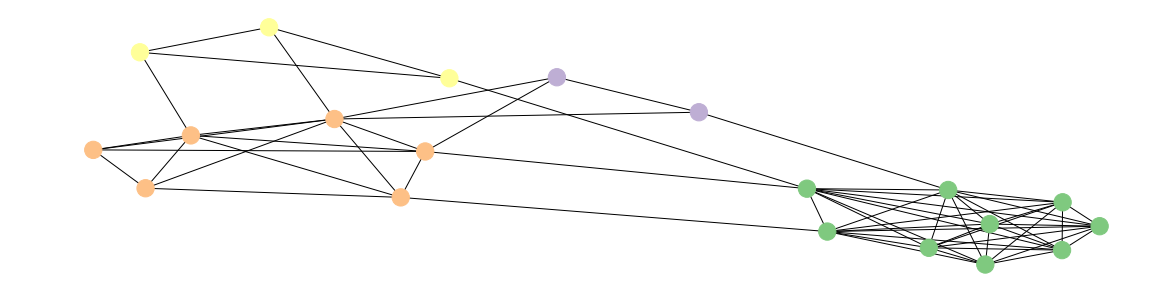

In [3]:
cmap = plt.cm.get_cmap('Accent')
# node_color = [cmap.colors[c] for (n, c) in nxG.nodes.data('colorsindex')]
plt.figure(figsize=(20, 5))
nx.draw_networkx(nxG, pos=pos, node_color=[cmap.colors[nxG.node[n]["gt"]] for n in nxG.nodes], with_labels=False)
plt.axis('off')

def draw_from_partition_dict(part_dict, cmap = plt.cm.get_cmap('Accent').colors + plt.cm.get_cmap('tab20c').colors,
                             figsize=(20, 5), **kwargs):
    if "figure" not in kwargs:
        plt.figure(figsize=figsize)
    nx.draw_networkx(nxG, pos=pos, node_color=[cmap[part_dict[n]] for n in nxG.nodes], with_labels=False, **kwargs)
    plt.axis('off')
    plt.show()

In [4]:
def __PLP(G, startDict, getNeighbors, step_plot=True, **kwargs):
    if step_plot: print("-" * 3, "Initialization", "-" * 3)
    dicoLabels, nbIter, nodes = startDict(G), 0,  G.nodes()
    if step_plot: draw_from_partition_dict(dicoLabels, **kwargs)
    acha = []
    change = True
    
    while change:
        ordre = list(range(len(nodes)))
        random.shuffle(ordre)
        nb_change = 0
        for n in ordre:
            voisins = getNeighbors(n)
            if (len(voisins) > 0):
                labels = [dicoLabels[v] for v in voisins]
                c = Counter(labels)
                old_label_count = c[dicoLabels[n]]
                newlabel, newcount = c.most_common(1)[0]
                if newlabel != dicoLabels[n] and newcount > old_label_count:
                    dicoLabels[n] = newlabel
                    nb_change += 1
        nbIter += 1
        acha.append(nb_change)
        if nb_change == 0 or nbIter > 100:
            change = False
        if step_plot: 
            print("-" * 3, f"Step {nbIter}", "-" * 3)
            draw_from_partition_dict(dicoLabels, **kwargs)
    print(Counter(acha))
    print("Nb Iter", nbIter)
    continousCid = {c: i for i, c in enumerate(sorted(list(set(dicoLabels.values()))))}
    return nk.community.Partition(len(nodes),[continousCid[dicoLabels[n]] for n in sorted(dicoLabels)])

def LP(G, **kwargs):
    print("*" * 5, "LP", "*" * 5)
    def allToSingletons(G):
        return {n:i for i, n in enumerate(G.nodes())}
    
    return __PLP(G, startDict=allToSingletons,
                    getNeighbors=G.neighbors, **kwargs)

def SLP(G, inter, intra, **kwargs):
    print("*" * 5, "SLP", "*" * 5)
    # O(n) version presented for conference
    def startDict(G):
        dicoLabels, cpt = dict(), 0
        for n in G.nodes():
            if n not in dicoLabels:
                dicoLabels[n] = cpt
                voisins = intra[n]
                for v in voisins:
                    dicoLabels[n] = cpt
                cpt += 1
        return dicoLabels

    # O(n * n) but with a better starting point 
    def startDict_pred(G):
        dicoLabels, cpt = dict(), 0
        predictions = {}
        for n in G.nodes():
            if n not in dicoLabels:
                predictions[n] = {cpt: 1}
                dicoLabels[n] = cpt
#                 print(f"{n} create this own group")
                cpt += 1
            for v in intra[n]:
                if v not in dicoLabels:
                    predictions[v] = {dicoLabels[n]: 1}
                    dicoLabels[v] = dicoLabels[n]
#                     print(f"{n} add {v} in {dicoLabels[n]}")
                else:
                    predictions[v][dicoLabels[n]] = predictions[v].get(dicoLabels[n], 0) + 1
                    if predictions[v][dicoLabels[v]] < predictions[v][dicoLabels[n]]:
#                         print(f"{n} change {v} from {dicoLabels[v]} to  {dicoLabels[n]}")
                        dicoLabels[v] = dicoLabels[n]
#         print(predictions)
        return dicoLabels
    
    # O(n * n) variation using confidence spreading
    def startDict_pred_conf(G):
        dicoLabels, cpt = dict(), 0
        predictions = {}
        for n in G.nodes():
            if n not in dicoLabels:
                predictions[n] = {cpt: 1}
                dicoLabels[n] = cpt
#                 print(f"{n} create this own group")
                cpt += 1
            for v in intra[n]:
                if v not in dicoLabels:
                    predictions[v] = {dicoLabels[n]: predictions[n][dicoLabels[n]]}
                    dicoLabels[v] = dicoLabels[n]
#                     print(f"{n} add {v} in {dicoLabels[n]}")
                else:
                    predictions[v][dicoLabels[n]] = predictions[v].get(dicoLabels[n], 0) + predictions[n][dicoLabels[n]]
                    if predictions[v][dicoLabels[v]] < predictions[v][dicoLabels[n]]:
#                         print(f"{n} change {v} from {dicoLabels[v]} to  {dicoLabels[n]}")
                        dicoLabels[v] = dicoLabels[n]
#         print(predictions)            
        return dicoLabels

    def getNeighbors(n):
        voisins = set(G.neighbors(n))
        not_voisins = set(inter[n])
        return voisins.difference(not_voisins)

    return __PLP(G, startDict=startDict_pred, getNeighbors=getNeighbors, **kwargs)


In [5]:
def partitionRes(G, gt_partition, detected, method, norm, verbose=True):
    res = {}
    if verbose:
        print(f"__________\nNormalisation :{norm}\nMethod: {method}\n__________")
    res[f"numberOfCom_{method}_{norm}"] = detected.numberOfSubsets()
    NMI = nk.community.NMIDistance().getDissimilarity(G, gt_partition, detected)
    if verbose:
        print(f"{gt_partition.numberOfSubsets()} community detected")
        print(f"NMI:{NMI}")
    res[f"NMI_{method}_{norm}"] = NMI
    ARI = nk.community.AdjustedRandMeasure().getDissimilarity(G, gt_partition, detected)
    res[f"ARI_{method}_{norm}"] = ARI
    if verbose:
        print(f"ARI:{ARI}\n")
        print(f"__________")
    return res
partitionRes(G, com, com, "LP", "")

__________
Normalisation :
Method: LP
__________
4 community detected
NMI:0.0
ARI:0.0

__________


{'numberOfCom_LP_': 4, 'NMI_LP_': 0.0, 'ARI_LP_': 0.0}

***** LP *****
--- Initialization ---


/home/victor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


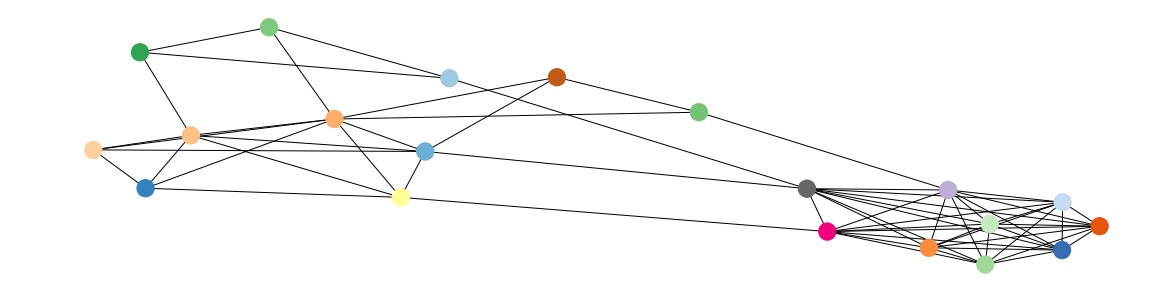

--- Step 1 ---


/home/victor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


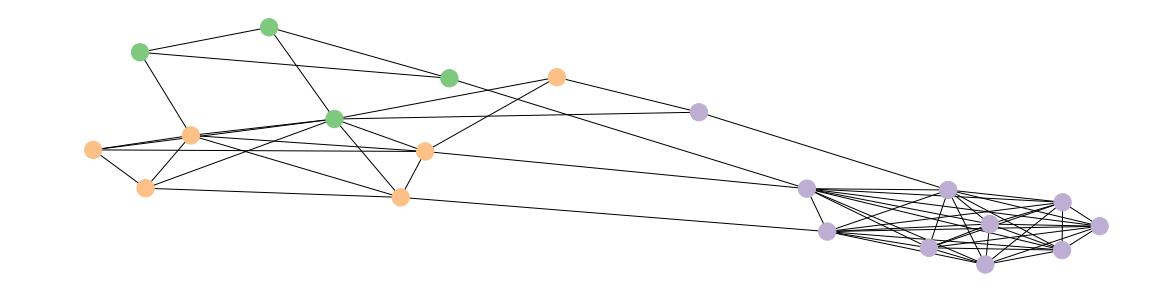

--- Step 2 ---


/home/victor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


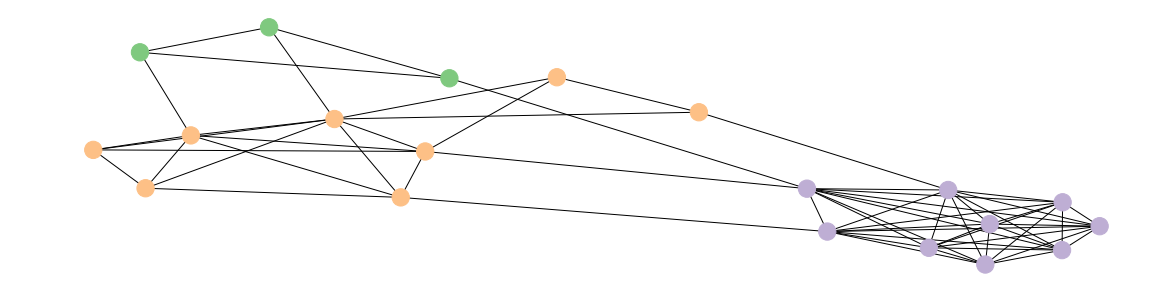

--- Step 3 ---


/home/victor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


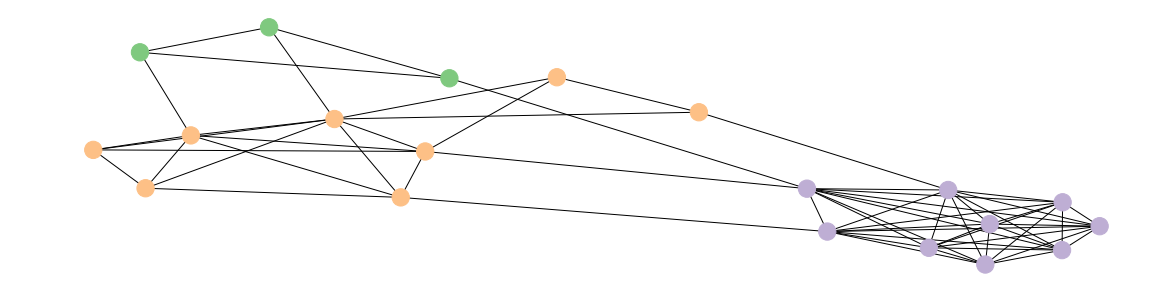

Counter({17: 1, 2: 1, 0: 1})
Nb Iter 3
__________
Normalisation :
Method: LP
__________
4 community detected
NMI:0.10015945665430015
ARI:0.1428571428571429

__________


{'numberOfCom_LP_': 3,
 'NMI_LP_': 0.10015945665430015,
 'ARI_LP_': 0.1428571428571429}

In [6]:
PLPCOM = LP(G, step_plot=True)
partitionRes(G, com, PLPCOM, "LP", "")

***** SLP *****
--- Initialization ---


/home/victor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


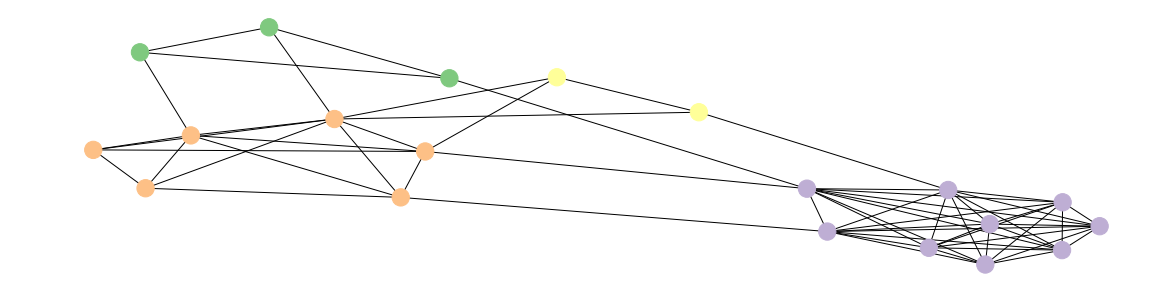

--- Step 1 ---


/home/victor/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


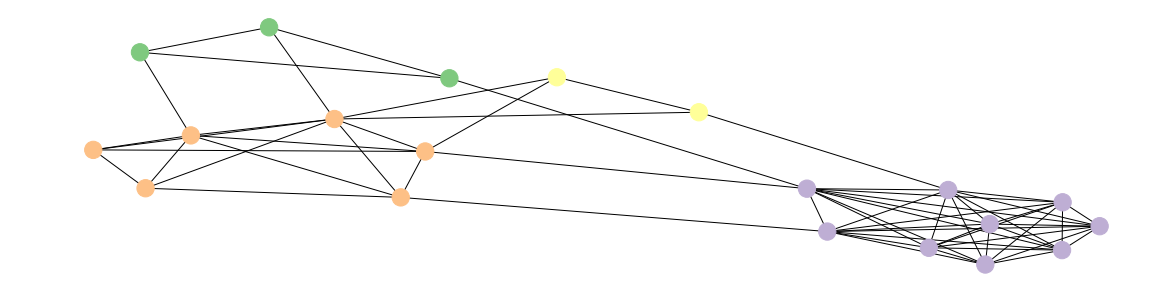

Counter({0: 1})
Nb Iter 1
__________
Normalisation :
Method: SLP
__________
4 community detected
NMI:0.0
ARI:0.0

__________


{'numberOfCom_SLP_': 4, 'NMI_SLP_': 0.0, 'ARI_SLP_': 0.0}

In [7]:
inter_recall, intra_recall, inter_prec, intra_prec = 0.29, 0.86, 0.82, 0.49
# inter_recall, intra_recall, inter_prec, intra_prec = 1, 1, 1, 1

inter, intra = {}, {}
odd = random.random
intercond = lambda u, v: (com.subsetOf(u) != com.subsetOf(v) and inter_recall > odd()) or (1 - inter_prec) < odd()
intracond = lambda u, v: (com.subsetOf(u) == com.subsetOf(v) and intra_recall > odd()) or (1 - intra_prec) < odd()
for u in G.nodes():
    inter[u] = [v for v in G.neighbors(u) if intercond(u, v)]
    intra[u] = [v for v in G.neighbors(u) if intracond(u, v)]
# print(inter)
# print(intra)
SLPCOM = SLP(G, intra=intra, inter=inter, step_plot=True)
partitionRes(G, com, SLPCOM, "SLP", "")